In [5]:
import pandas as pd
import numpy as np

!pip install pydot
!pip install graphviz
import pydot
from PIL import Image
from io import BytesIO
from IPython.display import display

## Decision Tree Classifier

In [6]:
class Node_cls:
    """
    Initializes "Node class constructor" for classification problems which stores and initialises:
    Feature index used for best split :  feature = None,
    Left child node :  left_spl = None,
    Right child node :  right_spl = None,
    Node Splitting threshold value :  spl_val = None,
    Information Value gain:  info_gain = None,
    Output value of the node :  out_val = None
    """

    def __init__(
        self,
        feature=None,
        spl_val=None,
        left_spl=None,
        right_spl=None,
        info_gain=None,
        *,
        out_val=None
    ):
        self.feature = feature
        self.threshold = spl_val
        self.left = left_spl
        self.right = right_spl
        self.info_gain = info_gain
        self.output = out_val

    # function to check whether a leaf node or not
    def is_leaf_node(self):
        return self.output is not None


In [7]:
class DecisionTreeClassifier:
    """
    Initializes "Decision Tree constructor" for classification problems which stores and initialises:
    Maximum tree depth : max_depth=100,
    Minimum samples reuqired for splitting nodes : min_samples_split=2,
    Number of features to be used for tree: n_features=None,
    Cost function/ Loss criterion for splitting nodes : criterion='entropy'

    """

    def __init__(
        self, max_depth=100, min_samples_split=2, n_features=None, criterion="entropy"
    ):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.criterion = criterion
        self.root = None

    # # For storing tree structure to generate tree graph visualization
    #     self.tree = None
    #     self.graph = None
    #     self.list_node_names = []

    """
  Defines the train method of the DecisionTree class, 
  which takes two inputs: 
  1. X, a matrix of input features
  2. y, a vector of output labels
  Then, uses the _build_tree function to proceed with growing the decision tree structure
  """

    def train(self, X, y):
        # sets self.n_features to number of features in the input if n_features is not specified,
        # Else, the minimum of n_features and the number of features in the input data if n_features is specified to avoid exceeding the maximum feature limit

        self.n_features = (
            X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        )
        self.root = self._build_tree(X, y)

    """
  Defines the recursive "_build_tree" function of the DecisionTree class, 
  which takes two inputs: 
  1. X, a matrix of input features
  2. y, a vector of output labels

  Returns Tree Nodes after each iteration
  """

    def _build_tree(self, X, y, depth=0):
        # stores the number of observations and features in the input data
        n_obs, n_fts = X.shape

        # stores the number of output classes in the input data
        n_classes = len(np.unique(y))

        # checks for stopping conditions of a decision tree, if met returns the leaf node
        if n_classes == 1 or depth >= self.max_depth or n_obs <= self.min_samples_split:
            leaf_val = self._dominant_class(y)
            return Node_cls(out_val=leaf_val)

        # checks for all possible splits across features and returns the best split threshold and feature column index
        best_gain = -1
        best_feature, best_thresh = None, None
        criterion = self.criterion

        # random selection of specified number of features out of all the available features
        select_fts = np.random.choice(n_fts, self.n_features, replace=False)

        for feature in select_fts:
            thresholds = np.unique(X[:, feature])
            for thresh in thresholds:
                gain = self._information_gain(y, X[:, feature], thresh, criterion)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_thresh = thresh

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node_cls(
            feature=best_feature,
            spl_val=best_thresh,
            left_spl=left,
            right_spl=right,
            info_gain=best_gain,
        )

    """
  Defines the most commom class/ label function  
  which takes input as y, a vector of output labels and returns the class with highest frequency
  """

    def _dominant_class(self, y):
        classes, class_counts = np.unique(y, return_counts=True)
        return classes[class_counts.argmax()]

    """
  Defines the node splitting function which takes as input
  data : the subset input data based on a feature index
  split_thresh : Specified split threshold to split the tree in left and right child nodes

  Returns : Indices of left and right child nodes
  """

    def _split(self, data, split_thresh):
        left_idxs = np.argwhere(data <= split_thresh).flatten()
        right_idxs = np.argwhere(data > split_thresh).flatten()
        return left_idxs, right_idxs

    """
  Defines the information_gain funtion which takes as input
  y_parent : Parent node data for labels
  X_ft : the subset input data based on a feature index
  split_thresh : Specified split threshold to split the tree in left and right child nodes
  criterion : Criterion to calculate node impurity values

  Returns : Information gain value as we move from a parent node to child nodes
  """

    def _information_gain(self, y_parent, X_ft, threshold, criterion):
        if criterion.lower() == "entropy":
            # parent entropy
            parent_entropy = self._entropy(y_parent)

            # create children
            left_idxs, right_idxs = self._split(X_ft, threshold)
            if len(left_idxs) == 0 or len(right_idxs) == 0:
                return 0

            # calculate the weighted avg. entropy of children
            n = len(y_parent)
            p_left, p_right = len(left_idxs) / n, len(right_idxs) / n
            e_left, e_right = self._entropy(y_parent[left_idxs]), self._entropy(
                y_parent[right_idxs]
            )

            child_entropy = p_left * e_left + p_right * e_right

            # calculate the IG
            information_gain = parent_entropy - child_entropy

        elif criterion.lower() == "gini":
            # parent gini impurity
            parent_gini = self._gini_impurity(y_parent)

            # create children
            left_idxs, right_idxs = self._split(X_ft, threshold)
            if len(left_idxs) == 0 or len(right_idxs) == 0:
                return 0

            # calculate the weighted avg. gini impurity of children
            n = len(y_parent)
            p_left, p_right = len(left_idxs) / n, len(right_idxs) / n
            g_left, g_right = self._gini_impurity(
                y_parent[left_idxs]
            ), self._gini_impurity(y_parent[right_idxs])

            child_gini = p_left * g_left + p_right * g_right

            # calculate the IG
            information_gain = parent_gini - child_gini

        else:
            information_gain = -1

        return information_gain

    """
  Defines the entropy function which takes as input
  y_parent : data of label for a node

  Returns : Entropy of the node
  """

    def _entropy(self, y):
        n = len(y)
        _, counts = np.unique(y, return_counts=True)
        ps = counts / n
        ps_nonzero = ps[ps > 0]  # exclude labels with probability 0
        return -np.sum(ps_nonzero * np.log2(ps_nonzero))

    """
  Defines the gini impurity function which takes as input
  y_parent : data of label for a node

  Returns : Gini Impurity of the node
  """

    def _gini_impurity(self, y):
        n = len(y)
        _, counts = np.unique(y, return_counts=True)
        ps = counts / n
        return 1 - np.sum(np.square(ps))

    """
  Defines the predict method of the Decision Tree Classifier which takes as input
  X : Test/ Valdiation dataset for features

  Returns : Array of Prediction classes after traversing through each observation or row in "X"
  """

    def predict(self, X):
        return np.array([self._traverse_dtree(x, self.root) for x in X])

    """
  Defines the recursive "_traverse_dtree" function which takes as input
  x : one single row/ observation of the test/validation data
  node : information of parent node to traverse down the tree to leaf
  """

    def _traverse_dtree(self, x, node):

        # Checks for leaf node, if satisfied returns the node output value, else keeps on traversing
        if node.is_leaf_node():
            return node.output

        # Checks if observation has the feature with value according to left child node (<= threshold) and keeps on traversing in the left splits
        if x[node.feature] <= node.threshold:
            return self._traverse_dtree(x, node.left)

        # Finally traverses on the right child node
        return self._traverse_dtree(x, node.right)

    """
    Defines the recursive "print_tree" function which returns the text print of the trained decision tree
    """

    def print_tree(self, tree=None, indent=" "):
        """function to print the tree"""
        if not tree:
            tree = self.root

        if tree.output is not None:
            print(tree.output)

        else:
            print(
                "X_" + str(tree.feature),
                "<=",
                tree.threshold,
                "?",
                round(tree.info_gain, 4),
            )
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    """
    Defines the recursive "_tree_to_dict" function which returns the dictionary of nodes of the trained decision tree
    """

    def _tree_to_dict(self, tree=None):
        """function to convert tree to dictionary"""
        if not tree:
            tree = self.root

        if tree.output is not None:
            return tree.output

        else:
            left = self._tree_to_dict(tree.left)
            right = self._tree_to_dict(tree.right)

        return {
            "feature": "X_" + str(tree.feature),
            "threshold": tree.threshold,
            "info_gain": round(tree.info_gain, 4),
            "left": left,
            "right": right,
        }
    """
    Defines the "visualize_tree" function which returns tree diagram of trained decision tree
    """

    def visualize_tree(self):
        graph = pydot.Dot(graph_type="digraph")
        tree_dict = self.tree
        split_index = [0]  # List to keep track of split index

        def add_node(node_dict):
            node_label = f"{node_dict['feature']} <= {node_dict['threshold']}"
            node = pydot.Node(node_label)
            graph.add_node(node)

            if isinstance(node_dict["left"], dict):
                left_node = add_node(node_dict["left"])
                graph.add_edge(pydot.Edge(node, left_node, label="True"))
            else:
                lbl_l = str(node_dict["left"])
                leaf_node_label = f"Leaf-{split_index[0]} \n Class-{lbl_l} \n"
                split_index[0] += 1  # Increment split index
                leaf_node = pydot.Node(
                    leaf_node_label, shape="box", style="filled", fillcolor="lightgreen"
                )
                graph.add_node(leaf_node)
                graph.add_edge(pydot.Edge(node, leaf_node, label="True"))

            if isinstance(node_dict["right"], dict):
                right_node = add_node(node_dict["right"])
                graph.add_edge(pydot.Edge(node, right_node, label="False"))
            else:
                lbl_r = str(node_dict["right"])
                leaf_node_label = f"Leaf-{split_index[0]} \n Class-{lbl_r} \n"
                split_index[0] += 1  # Increment split index
                leaf_node = pydot.Node(
                    leaf_node_label, shape="box", style="filled", fillcolor="lightblue"
                )
                graph.add_node(leaf_node)
                graph.add_edge(pydot.Edge(node, leaf_node, label="False"))

            return node

        add_node(tree_dict)
        Image.open(BytesIO(graph.create_png())).show()

# Testing on Dataset

In [8]:
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Train the decision tree with entropy method
tic = time.perf_counter()
clf = DecisionTreeClassifier(min_samples_split= 30, max_depth= 8, n_features = 5, criterion = 'entropy')
clf.train(X_train, y_train)
toc = time.perf_counter()

print(f"Build time {toc - tic:0.4f} seconds")

predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print(acc)

Build time 0.8286 seconds
0.9440559440559441


In [9]:
clf.print_tree()

X_7 <= 0.05074 ? 0.5632
 left:X_23 <= 880.8 ? 0.1169
  left:X_21 <= 23.31 ? 0.0274
    left:1
    right:X_0 <= 11.75 ? 0.0376
        left:1
        right:X_1 <= 21.57 ? 0.058
                left:X_11 <= 1.909 ? 0.1565
                                left:1
                                right:0
                right:1
  right:0
 right:X_20 <= 17.5 ? 0.1997
  left:X_26 <= 0.2573 ? 0.2985
    left:1
    right:X_16 <= 0.1166 ? 0.2144
        left:X_28 <= 0.2848 ? 0.281
                left:0
                right:0
        right:1
  right:0


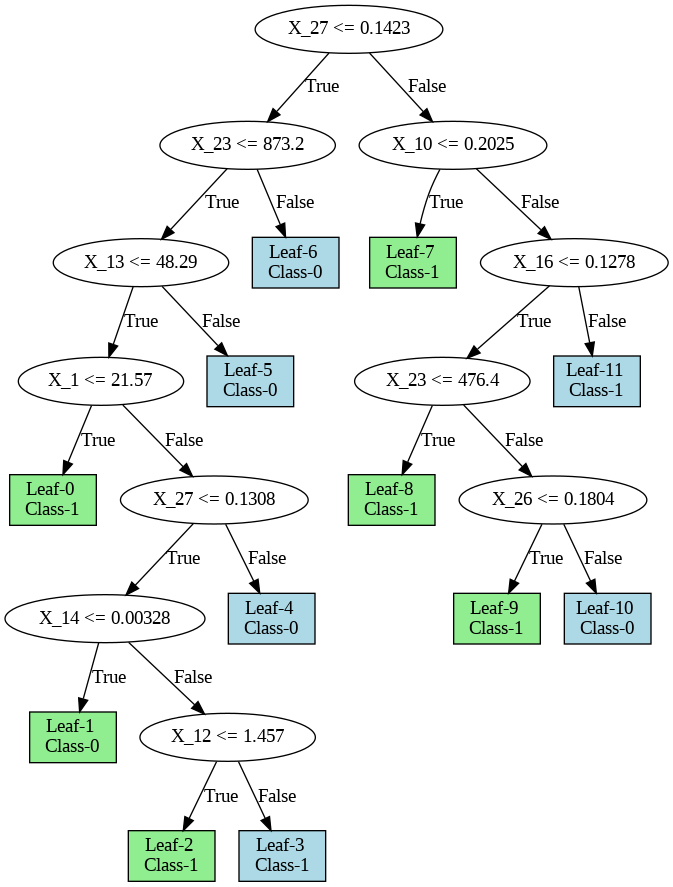

In [11]:
clf.visualize_tree()